## Score Model w/ Weather EDA

### Objective

* Evaluation of basic linear model using weather factors and previous scores

### Rationale

*  Why This?  Before establishing a baseline model, the performance implications of various model choices need to be explored.

*  Why Me?  Because I will be building the baseline model, I am the logical choice

*  Why Now?  Data from a reproducible pipeline is now available; understanding model choices is necessary before continuing on the project critical path of model implementation

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks/eda`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/linear_model_fits.csv`

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,course_id
0,0,2018-11-18,6.863194,0.005417,51.130278,72.556944,3.365000,7.305000,93.317917,0.000000,2.201613,1.558933,0
1,1,2019-03-11,0.302778,0.002167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,2018-11-04,13.681944,0.001056,57.929792,231.829722,2.637569,5.607500,82.701042,0.000817,-2.128643,-1.196988,0
3,3,2019-03-17,5.604167,0.000000,68.041667,215.895833,0.980324,1.526620,48.973380,0.000000,-0.654349,-0.149641,1
4,4,2018-12-02,6.694444,0.000000,51.899537,74.433333,1.561806,5.042824,66.128935,0.000000,0.997931,0.962995,0


In [4]:
scores_df.head()

,Unnamed: 0,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61.0,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60.0,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55.0,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59.0,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53.0,-1.50,51.50,2019-01-19 08:00:00,1


In [5]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'Unnamed: 0')

In [6]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [7]:
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
0,Alex Torres,68.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop any rows that do not have weather data
all_df = all_df.dropna(subset = ['w_spd'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
521,Anni Kreml,57.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
522,Bob Montes,61.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
523,Case Conover,56.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
524,Conner Russell,69.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
525,David Falzone,58.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677


In [9]:
len(all_df)

2945

In [20]:
lc_df = all_df[(all_df['Name'] == 'Luiz Celeste') & (all_df['course_id'] == 2)]
lc_df

,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
1372,Luiz Celeste,60.0,NaN,NaN,2018-08-29 09:00:00,2,2018-08-29,17.708333,0.000000,67.083333,236.534722,4.133333,6.011111,82.479167,0.000000,-3.147156,-1.933963
1387,Luiz Celeste,57.0,NaN,NaN,2018-09-05 09:00:00,2,2018-09-05,21.347222,0.000000,21.786111,70.946528,1.268750,2.104167,29.195833,0.000000,-0.505402,-0.852625
1432,Luiz Celeste,54.0,NaN,NaN,2018-09-12 09:00:00,2,2018-09-12,12.694444,0.000000,63.997222,172.837500,1.994444,3.255556,77.193056,0.000000,0.153408,-1.620832
1446,Luiz Celeste,54.0,NaN,NaN,2018-09-19 09:00:00,2,2018-09-19,13.736111,0.000000,68.479167,235.773611,1.173611,2.175000,67.068056,0.000000,-0.753760,-0.586079
1461,Luiz Celeste,54.0,NaN,NaN,2018-09-26 09:00:00,2,2018-09-26,12.680556,0.000000,58.759722,227.368056,3.334722,5.568056,89.990278,0.000000,-2.209334,-1.539630
1473,Luiz Celeste,51.0,NaN,NaN,2018-10-03 09:00:00,2,2018-10-03,15.013889,0.000000,66.620833,234.077778,3.708333,5.533333,86.894444,0.000000,-2.633957,-1.604132
1495,Luiz Celeste,60.0,NaN,NaN,2018-10-17 09:00:00,2,2018-10-17,9.409722,0.000000,58.848611,215.902778,2.295833,4.216667,86.763889,0.000000,-1.511052,-1.217441
1508,Luiz Celeste,51.0,NaN,NaN,2018-10-24 09:00:00,2,2018-10-24,3.493056,0.000000,61.233333,169.557639,1.043750,1.957639,83.404861,0.000000,-0.083833,-0.609559
1519,Luiz Celeste,54.0,NaN,NaN,2018-10-31 09:00:00,2,2018-10-31,5.548611,0.000000,64.273611,194.716667,0.531944,0.994444,68.490278,0.000000,-0.159501,-0.407044
1621,Luiz Celeste,54.0,NaN,NaN,2018-11-10 09:00:00,2,2018-11-10,1.500000,0.000000,59.349537,171.550926,0.400463,0.710648,40.761574,0.000000,0.026350,-0.340126


In [11]:
lc_df = lc_df.reset_index()
lc_df = lc_df.drop(columns = 'index')
lc_df

,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
0,Luiz Celeste,60.0,NaN,NaN,2018-08-29 09:00:00,2,2018-08-29,17.708333,0.000000,67.083333,236.534722,4.133333,6.011111,82.479167,0.000000,-3.147156,-1.933963
1,Luiz Celeste,57.0,NaN,NaN,2018-09-05 09:00:00,2,2018-09-05,21.347222,0.000000,21.786111,70.946528,1.268750,2.104167,29.195833,0.000000,-0.505402,-0.852625
2,Luiz Celeste,54.0,NaN,NaN,2018-09-12 09:00:00,2,2018-09-12,12.694444,0.000000,63.997222,172.837500,1.994444,3.255556,77.193056,0.000000,0.153408,-1.620832
3,Luiz Celeste,54.0,NaN,NaN,2018-09-19 09:00:00,2,2018-09-19,13.736111,0.000000,68.479167,235.773611,1.173611,2.175000,67.068056,0.000000,-0.753760,-0.586079
4,Luiz Celeste,54.0,NaN,NaN,2018-09-26 09:00:00,2,2018-09-26,12.680556,0.000000,58.759722,227.368056,3.334722,5.568056,89.990278,0.000000,-2.209334,-1.539630
5,Luiz Celeste,51.0,NaN,NaN,2018-10-03 09:00:00,2,2018-10-03,15.013889,0.000000,66.620833,234.077778,3.708333,5.533333,86.894444,0.000000,-2.633957,-1.604132
6,Luiz Celeste,60.0,NaN,NaN,2018-10-17 09:00:00,2,2018-10-17,9.409722,0.000000,58.848611,215.902778,2.295833,4.216667,86.763889,0.000000,-1.511052,-1.217441
7,Luiz Celeste,51.0,NaN,NaN,2018-10-24 09:00:00,2,2018-10-24,3.493056,0.000000,61.233333,169.557639,1.043750,1.957639,83.404861,0.000000,-0.083833,-0.609559
8,Luiz Celeste,54.0,NaN,NaN,2018-10-31 09:00:00,2,2018-10-31,5.548611,0.000000,64.273611,194.716667,0.531944,0.994444,68.490278,0.000000,-0.159501,-0.407044
9,Luiz Celeste,54.0,NaN,NaN,2018-11-10 09:00:00,2,2018-11-10,1.500000,0.000000,59.349537,171.550926,0.400463,0.710648,40.761574,0.000000,0.026350,-0.340126


In [21]:
lc_df = lc_df.reset_index()
lc_df

,index,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
0,1372,Luiz Celeste,60.0,NaN,NaN,2018-08-29 09:00:00,2,2018-08-29,17.708333,0.000000,67.083333,236.534722,4.133333,6.011111,82.479167,0.000000,-3.147156,-1.933963
1,1387,Luiz Celeste,57.0,NaN,NaN,2018-09-05 09:00:00,2,2018-09-05,21.347222,0.000000,21.786111,70.946528,1.268750,2.104167,29.195833,0.000000,-0.505402,-0.852625
2,1432,Luiz Celeste,54.0,NaN,NaN,2018-09-12 09:00:00,2,2018-09-12,12.694444,0.000000,63.997222,172.837500,1.994444,3.255556,77.193056,0.000000,0.153408,-1.620832
3,1446,Luiz Celeste,54.0,NaN,NaN,2018-09-19 09:00:00,2,2018-09-19,13.736111,0.000000,68.479167,235.773611,1.173611,2.175000,67.068056,0.000000,-0.753760,-0.586079
4,1461,Luiz Celeste,54.0,NaN,NaN,2018-09-26 09:00:00,2,2018-09-26,12.680556,0.000000,58.759722,227.368056,3.334722,5.568056,89.990278,0.000000,-2.209334,-1.539630
5,1473,Luiz Celeste,51.0,NaN,NaN,2018-10-03 09:00:00,2,2018-10-03,15.013889,0.000000,66.620833,234.077778,3.708333,5.533333,86.894444,0.000000,-2.633957,-1.604132
6,1495,Luiz Celeste,60.0,NaN,NaN,2018-10-17 09:00:00,2,2018-10-17,9.409722,0.000000,58.848611,215.902778,2.295833,4.216667,86.763889,0.000000,-1.511052,-1.217441
7,1508,Luiz Celeste,51.0,NaN,NaN,2018-10-24 09:00:00,2,2018-10-24,3.493056,0.000000,61.233333,169.557639,1.043750,1.957639,83.404861,0.000000,-0.083833,-0.609559
8,1519,Luiz Celeste,54.0,NaN,NaN,2018-10-31 09:00:00,2,2018-10-31,5.548611,0.000000,64.273611,194.716667,0.531944,0.994444,68.490278,0.000000,-0.159501,-0.407044
9,1621,Luiz Celeste,54.0,NaN,NaN,2018-11-10 09:00:00,2,2018-11-10,1.500000,0.000000,59.349537,171.550926,0.400463,0.710648,40.761574,0.000000,0.026350,-0.340126


In [12]:
lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 4, random_state=42)

In [92]:
X = lc_df[['index','weighted_precip']].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [93]:
X_scaled.shape

(21, 2)

In [94]:
y = lc_df.Raw.values

In [95]:
lr.fit(X_scaled,y)

ElasticNetCV(alphas=None, copy_X=True, cv=4, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=42,
             selection='cyclic', tol=0.0001, verbose=0)

In [96]:
lr.score(X_scaled,y)

0.0

In [97]:
lr.intercept_

55.285714285714285

In [98]:
y.shape

(21,)

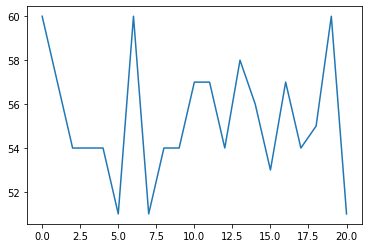

In [99]:
plt.plot(y)

In [100]:
lr.coef_

array([ 0.00000000e+00, -1.30448934e-17])

In [101]:
lr2 = LinearRegression()
lr2.fit(X,y)
lr2.score(X,y)

0.011183032160760331

In [102]:
lr2.coef_

array([ 1.74889109e-04, -1.36513872e+01])

In [103]:
lr2.intercept_

54.97008146047541

In [104]:
yp = lr2.predict(X)

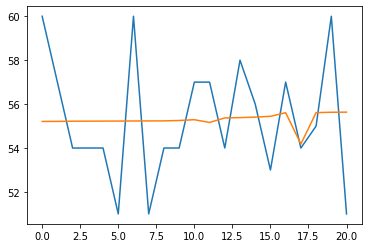

In [105]:
plt.plot(y)
plt.plot(yp)

In [56]:
lr3 = ElasticNet(l1_ratio = 0.5, alpha =0.1)

In [57]:
lr3.fit(X_scaled, y)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
lr3.coef_

array([-0.03123215,  0.7484978 , -0.6254135 ])

In [59]:
lr3.score(X_scaled, y)

0.07877806259635756

In [60]:
lr.alpha_

4.2989547206261856

In [61]:
lr.l1_ratio_

0.1

In [62]:
scores = cross_val_score(lr2, X_scaled, y, cv=4)
scores.mean()

-2.671216858418495

In [107]:
medians_df = all_df.groupby(['date','course_id']).median()
medians_df.head()

,,Raw,Handicap,Adjusted,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
date,course_id,,,,,,,,,,,,,
2017-03-15,2,55.0,NaN,NaN,13.402778,0.000000,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
2017-03-22,2,57.0,NaN,NaN,21.395833,0.110486,57.452083,207.297222,4.037500,0.0,62.796528,0.0,-1.970993,0.323788
2017-03-29,2,56.0,NaN,NaN,10.708333,0.000000,60.177083,162.647917,2.062500,0.0,61.956250,0.0,-0.102262,-1.215809
2017-04-05,2,60.0,NaN,NaN,6.243056,0.000000,62.146528,156.870139,1.201389,0.0,31.572917,0.0,0.616294,-0.197730
2017-04-12,2,61.0,NaN,NaN,0.472222,0.106250,62.077083,207.600000,0.097917,0.0,61.248611,0.0,-0.051002,-0.081538


In [113]:
mX = medians_df[['weighted_T','weighted_w_dir','weighted_w_spd','weighted_w_gust','weighted_rh','weighted_precip']].values
mscaler = StandardScaler().fit(mX)
mX_scaled = mscaler.transform(mX)
my = medians_df.Raw.values

In [114]:
lr4 = LinearRegression()
lr4.fit(mX_scaled, my)
lr4.score(mX_scaled, my)

0.19508580460836955

In [116]:
lr5 = ElasticNetCV(l1_ratio = [.1, .3, .5, .7, .9, .95], cv=4, random_state = 42)
lr5.fit(mX_scaled, my)
lr5.score(mX_scaled, my)

0.13845424680302365

In [117]:
lr5.coef_

array([-0.        , -0.        ,  0.        ,  0.5795832 , -0.        ,
        0.22656372])

In [125]:
mX2 = medians_df[['weighted_w_gust','weighted_precip']].values
mscaler = StandardScaler().fit(mX2)
mX2_scaled = mscaler.transform(mX2)
my = medians_df.Raw.values

In [126]:
lr6 = ElasticNetCV(l1_ratio = [.1, .3, .5, .7, .9, .95], cv=4, random_state = 42)
lr6.fit(mX2_scaled, my)
lr6.score(mX2_scaled, my)

0.16223424312387158

In [120]:
lr5.alpha_

0.41628579406791927

In [121]:
lr6.alpha_

0.3207791298888431

In [122]:
lr5.l1_ratio_

0.95

In [123]:
lr6.l1_ratio_

0.1

In [127]:
cross_val_score(lr6, mX2_scaled, my, cv=4)

array([0.05359079, 0.14844855, 0.05692905, 0.07398752])

In [128]:
myp = lr6.predict(mX2_scaled)

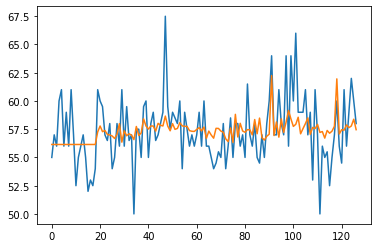

In [129]:
plt.plot(my)
plt.plot(myp)

In [133]:
medians_df['Handicap'].value_counts()

 0.000000    2
-2.400000    2
-0.600000    1
-2.960000    1
-1.593333    1
-0.230000    1
-5.070000    1
 2.420000    1
-1.426263    1
 1.920000    1
-0.320000    1
 0.735000    1
 1.720000    1
 2.530000    1
 0.945000    1
-1.280000    1
-2.000000    1
 2.250000    1
-1.433333    1
-1.066667    1
-2.310000    1
 1.755000    1
 1.710000    1
-3.035000    1
-1.990000    1
 1.135000    1
 1.295000    1
-0.400000    1
-1.900000    1
-4.665000    1
-2.914286    1
 2.080000    1
 1.455000    1
 2.295000    1
 0.670000    1
 0.330000    1
-2.133333    1
-1.200000    1
-0.035000    1
Name: Handicap, dtype: int64

In [134]:
medians_filled_df = medians_df.fillna('0')
medians_filled_df.head()

,,Raw,Handicap,Adjusted,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
date,course_id,,,,,,,,,,,,,
2017-03-15,2,55.0,0,0,13.402778,0.000000,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
2017-03-22,2,57.0,0,0,21.395833,0.110486,57.452083,207.297222,4.037500,0.0,62.796528,0.0,-1.970993,0.323788
2017-03-29,2,56.0,0,0,10.708333,0.000000,60.177083,162.647917,2.062500,0.0,61.956250,0.0,-0.102262,-1.215809
2017-04-05,2,60.0,0,0,6.243056,0.000000,62.146528,156.870139,1.201389,0.0,31.572917,0.0,0.616294,-0.197730
2017-04-12,2,61.0,0,0,0.472222,0.106250,62.077083,207.600000,0.097917,0.0,61.248611,0.0,-0.051002,-0.081538


In [141]:
mX3 = medians_filled_df[['Handicap','weighted_w_spd','weighted_precip']].values
m3scaler = StandardScaler().fit(mX3)
mX3_scaled = m3scaler.transform(mX3)
my3 = medians_filled_df.Raw.values

In [142]:
lr7 = ElasticNetCV(l1_ratio = [.05, .1, .2, .3, .5, .7, .9, .95, .99], cv=5, random_state = 42)

In [143]:
lr7.fit(mX3_scaled, my3)
lr7.score(mX3_scaled, my3)

0.09660561409211721

In [144]:
my3p = lr7.predict(mX3_scaled)

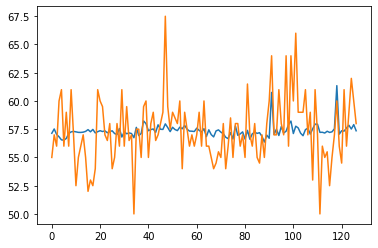

In [145]:
plt.plot(my3p)
plt.plot(my3)

In [149]:
medians_df.sort_values('Raw', ascending=False).head(5)

,,Raw,Handicap,Adjusted,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
date,course_id,,,,,,,,,,,,,
2018-05-30,2,67.5,NaN,NaN,38.270833,0.000000,59.340278,203.190278,5.888889,9.786111,75.934722,0.000000,-2.121530,-1.606747
2019-02-16,2,66.0,NaN,NaN,18.625000,0.047500,52.310185,271.340278,3.581019,5.474537,80.317130,0.011759,-3.158830,0.077893
2019-02-09,2,64.0,NaN,NaN,23.791667,0.129028,51.238426,155.215278,3.770833,5.652778,82.247685,0.025162,1.535865,-3.253974
2019-01-27,0,64.0,1.295,64.620,15.555556,0.000000,56.514352,66.074074,3.919907,7.743519,74.041204,0.000000,2.704494,2.301259
2019-01-06,0,64.0,-0.035,63.965,35.566551,0.525677,51.489236,152.649306,4.337500,10.733681,89.725694,0.103990,0.856727,-3.188937
